# Frequency Response Simulation and Analysis

In [1]:
using Pkg
Pkg.activate("FrequencyResponse")

  Activating environment at `~/project/MitoRetrogradeModel/MitoChannelAnalysis/FrequencyResponse/Project.toml`


In [2]:
using FrequencyResponse
using RetroSignalModel
using DifferentialEquations
using LaTeXStrings
import PyPlot
const plt = PyPlot;

┌ Info: Precompiling FrequencyResponse [23be90ff-b906-42a4-9508-8c19908ecbef]
└ @ Base loading.jl:1313


In [5]:
function show_all(sol)
        prl = Dict(
        :name=> [:bmhmks, :Rtg1_n, :Rtg3_n, :Rtg13_n],
        :label=> [string("Output\n",i)   for i in ["Bmh/Mksp (nM)", "Nucleus Rtg1p (nM)", "Nucleus Rtg3p (nM)", "Nucleus Rtg1/3p (nM)"]  ]
    )
    
    figs, axes = [], []
    
    for (n,l) in zip(prl[:name], prl[:label])
        fig_,ax_ = plotSol(sol, n, dynmodel; ylabel_output= l)
        push!(figs, fig_)
        push!(axes, ax_)
    end
    return Fig.(figs, axes,  prl[:name])
end;

## Setup

In [6]:
# Load Model
param= RetroSignalModel.rtgM4.param();
model = RetroSignalModel.rtgM4.model;

# Dynamical Signal
dynmodel = DynModel(
    model = RetroSignalModel.rtgM4.model,
    u = param.u,
    p = param.p,
    solver= Rosenbrock23(),
    signal_func = PosSine(ω=0.05,θ=(3/2)*π, amp=1),
    input_i = 1,
    tspan=(0.,500.),
    init_ss = true # Get steady state
);


## Sinusoidal Response

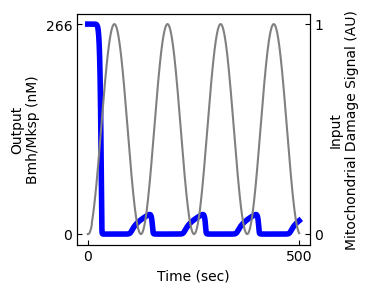

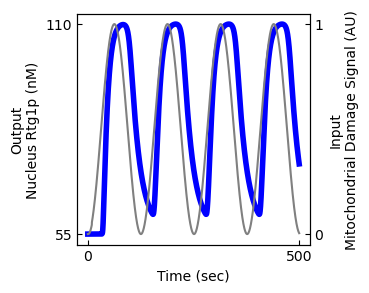

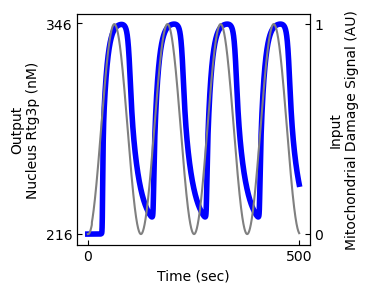

 15.689920 seconds (34.55 M allocations: 2.205 GiB, 6.48% gc time, 12.09% compilation time)


In [5]:
# Solve 
@time sol = solve(dynmodel;dtmax=1., reltol=1e-15,abstol=1e-8);
figsD_sin = show_all(sol);
[save.(figsD_sin, "Sine_5e-2rad", "FrequencyResponse/result/sine"; 
        format= f) for f in ["pdf", "svg"]];

## Hysteresis

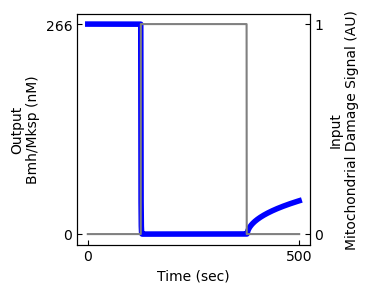

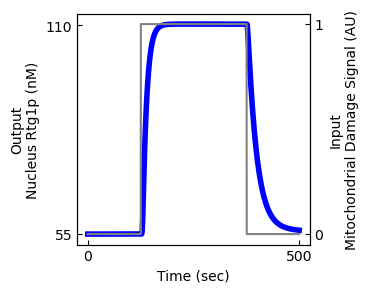

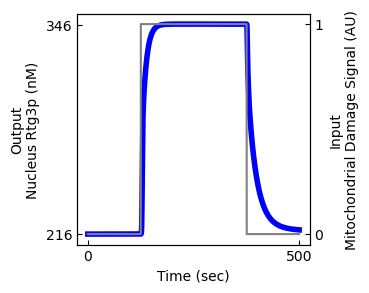

In [53]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(
                                    t_str = 125.,
                                    t_end = 375,
                                    amp_l =0.,
                                    amp_h = 1.) 
                        );
sol = solve(dynmodel_sq;tmax=1.);

figsD_SqPulse = show_all(sol);
[save.(figsD_SqPulse, "Pulse_150sec", "FrequencyResponse/result/pulse"; 
        format= f) for f in ["pdf", "svg"]];

## Multiple Step Response 

- Follower
- No overshoot

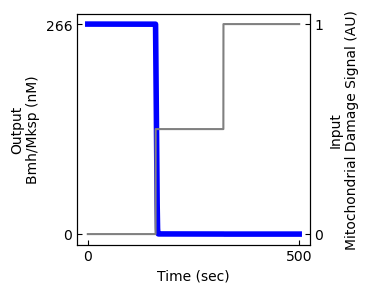

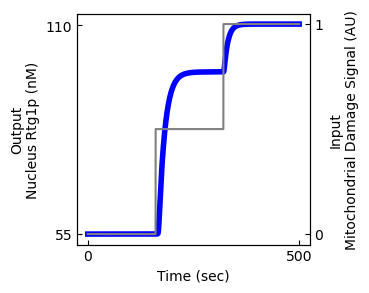

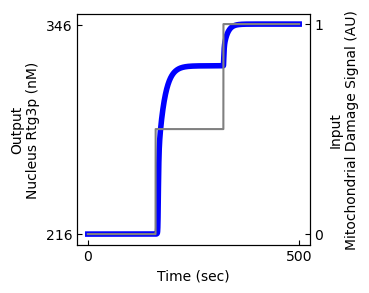

In [60]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(
                                    t_str = 0.,
                                    t_end = 160,
                                    amp_l =0.,
                                    amp_h = 0.)  +
                                    SquarePulse(
                                    t_str = 160.1,
                                    t_end = 320,
                                    amp_l =0,
                                    amp_h = 0.5)  +
                                    SquarePulse(
                                    t_str = 320.1,
                                    t_end = 500,
                                    amp_l =0,
                                    amp_h = 1.) 
                        );
solPulses = solve(dynmodel_sq;tmax=1.);

figsD_SqPulses = show_all(solPulses);

[save.(figsD_SqPulses, "Pulse_160sec320sec", "FrequencyResponse/result/pulse"; 
        format= f) for f in ["pdf", "svg"]];

## Merging Pulse and Sinusoidal Response

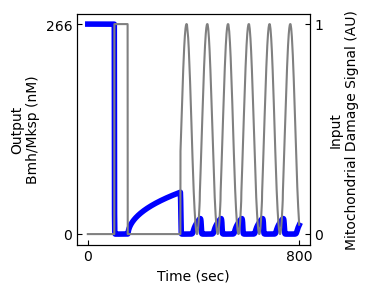

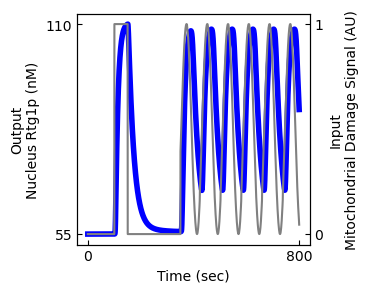

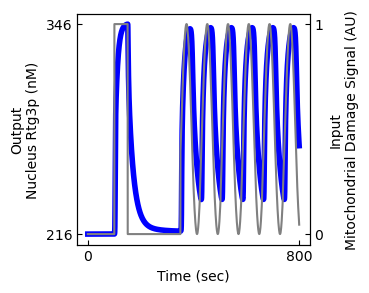

In [55]:
pulse = SquarePulse(t_str = 100.,t_end = 150.,amp_l =0., amp_h = 1.) 
sigFunc = pulse + SquarePulse(pulse; t_str=350, t_end=800.) * PosSine(ω=0.08, θ=π)

dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= sigFunc,
                        tspan=(0.,800.)
                        );
sol = solve(dynmodel_sq;tmax=0.5);

figsD_SquareSine = show_all(sol);
[save.(figsD_SquareSine, "SquareSine_150sec", "FrequencyResponse/result/squareSine"; format= f) for f in ["pdf", "svg"]];


## Impuse

### Short Impulse

- Short Impuse Injection (duration=1 sec)

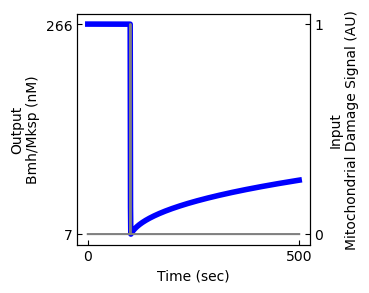

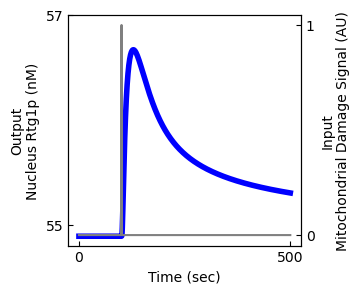

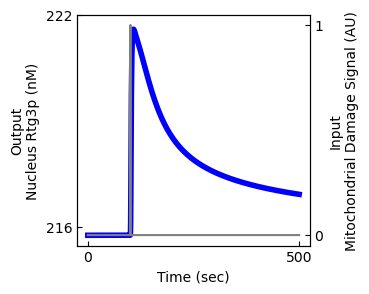

In [56]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(t_str = 100.,t_end = 101,amp_l =0., amp_h = 1.) ,
                        tspan=(0.,500.)
                        );
sol = solve(dynmodel_sq;tmax=0.5);

figsD_PulseShort = show_all(sol);

[save.(figsD_PulseShort, "Impulse_1ec", "FrequencyResponse/result/Impulse"; 
format= f) for f in ["pdf", "svg"]];

### Long Impulse
- Short Impulse with duation = 20 second

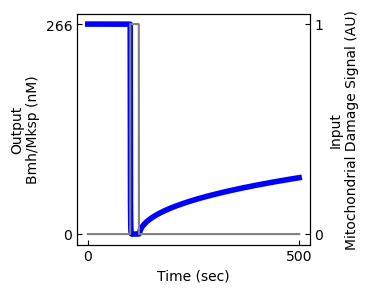

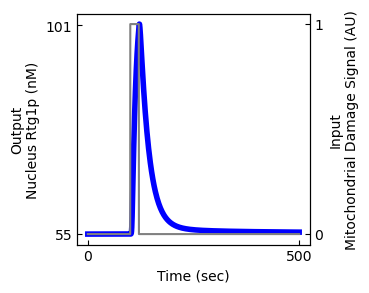

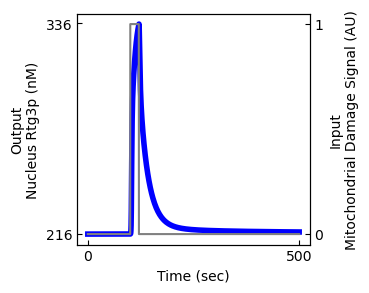

In [57]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(t_str = 100.,t_end = 120,amp_l =0., amp_h = 1.) ,
                        tspan=(0.,500.)
                        );
sol = solve(dynmodel_sq;tmax=0.2);

figsD_PulseLong = show_all(sol);

[save.(figsD_PulseLong, "Impulse_20ec", "FrequencyResponse/result/Impulse"; 
format= f) for f in ["pdf", "svg"]];

## Merging Signals

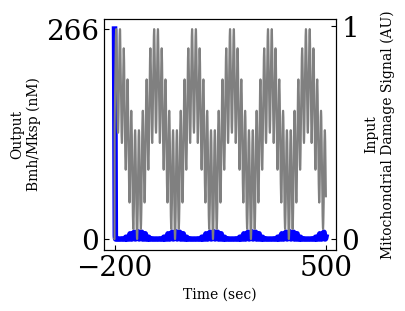

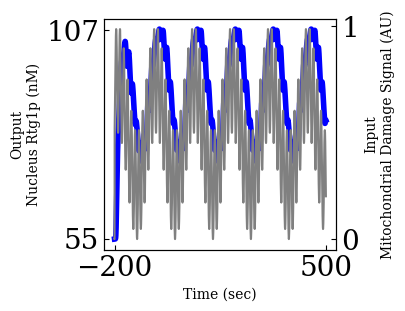

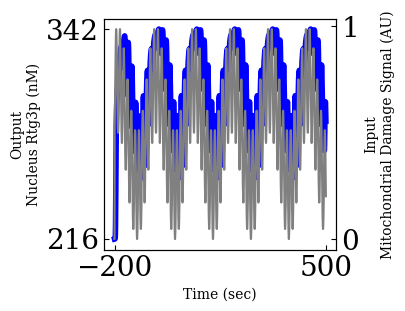

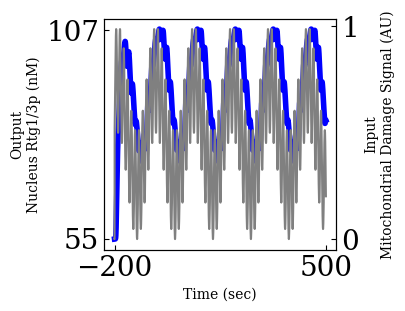

In [214]:
p1 = PosSine(ω=0.05,θ=π /2*3, amp=0.5)
p2 = PosSine(p1; ω=0.5)
dynmodel_ss = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= p1 + p2  ,
                        tspan=(-200.,500.)
                        );
sol = solve(dynmodel_ss;tmax=0.2);

figsD_PulseLong = show_all(sol);

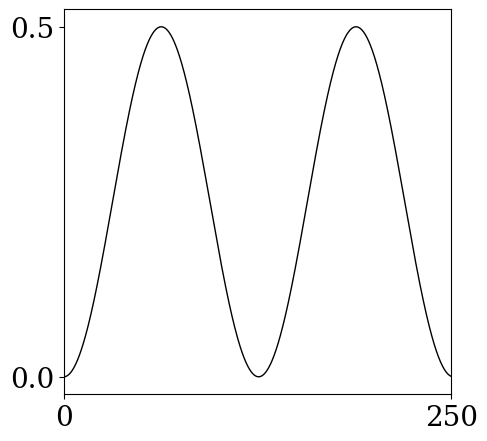

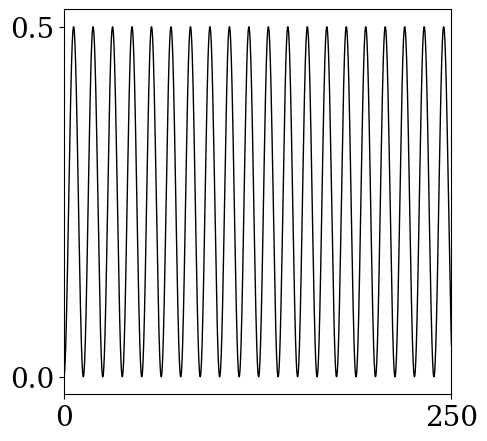

In [234]:
plt.rc("font", size="20")
function plotwave(ax, t, func;linewidth=1, linecolor="black")
    ydata = func.(t)
    ax.plot(t, ydata, linewidth=linewidth, color=linecolor)
    ax.set_xticks([minimum(t), maximum(t)])
    ax.set_yticks([minimum(ydata), maximum(ydata)])
    return ax
end

fig1,ax1=plt.subplots(figsize=(5,5))
fig2,ax2=plt.subplots(figsize=(5,5))
plotwave.([ax1,ax2], [0:0.1:500], [p1,p2])


ax1.set_xlim([0,250])
ax1.xaxis.set_ticks([0, 250])
ax2.set_xlim([0,250])
ax2.xaxis.set_ticks([0, 250])

#[a.set_xlabel("Time (seconds)") for a in [ax1,ax2]]
#[a.set_ylabel("Mitochondrial Damage (AU)") for a in [ax1,ax2]]

fig1.savefig("FrequencyResponse/result/synthetic_wave/sine_low_freq.pdf")
fig2.savefig("FrequencyResponse/result/synthetic_wave/sine_high_freq.pdf")

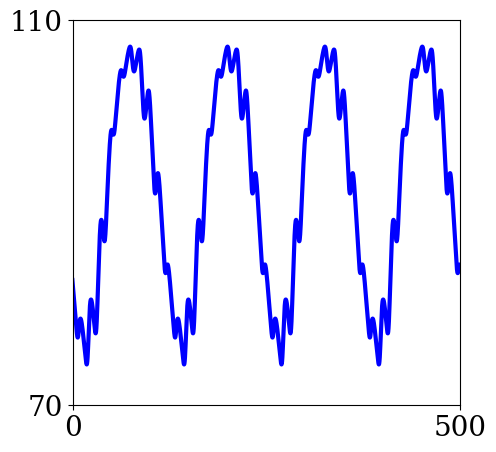

In [231]:
fig_, ax_ = plt.subplots(figsize=(5,5))
pr = RetroSignalModel.get_protein_lookup(RetroSignalModel.rtgM4.model)
ax_.plot(sol.t, [ sum(u[pr[:Rtg13_n]]) for u in sol.u], linewidth=3, color="blue")
ax_.xaxis.set_ticks([0,500])
ax_.set_xlim([0,500])
ax_.set_ylim([70,110])
ax_.yaxis.set_ticks([70,110])
fig_.savefig("FrequencyResponse/result/synthetic_wave/output_Rtg13_n.pdf", box_inches="tight")

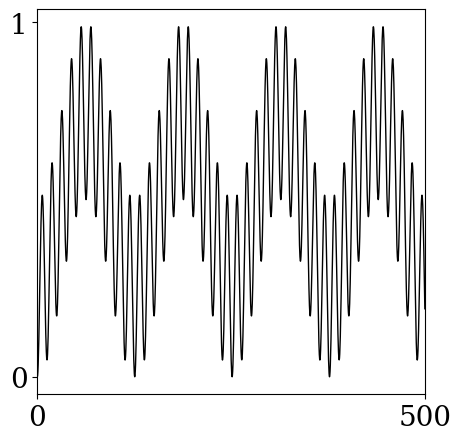

In [232]:
p12 = p1 + p2
fig_2, ax_2 = plt.subplots(figsize=(5,5))
ax_2.plot(sol.t, [ p12(t) for t in sol.t], linewidth=1, color="black" )
ax_2.set_xlim([0,500])
ax_2.xaxis.set_ticks([0,500])
ax_2.yaxis.set_ticks([0,1])
fig_2.savefig("FrequencyResponse/result/synthetic_wave/input.pdf", box_inches="tight")

## Plotting for Graphical Abstact

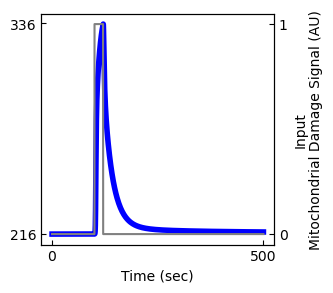

(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing)

In [58]:
solPulses 

plotSol(sol, :Rtg3_n, dynmodel_sq;)

### Increasing frequency of sine wave

In [76]:
function SINEV(t; t_start=0., t_end=600., ω_str=0.02, ω_end=0.7, amp=1.0, ϕ=π /2*3)
    ω_c = ω_str + (ω_end - ω_str)* (t-t_start)/(t_end-t_start)
    
    SIGNAL = 0.5*amp + 0.5*amp*sin(ω_c*t + ϕ)
    return SIGNAL
end


dynmodel_freq = DynModel(dynmodel; 
                       init_ss=false, 
                       tspan=(0.,600.),
                       signal_func= SINEV
                        );

sol = solve(dynmodel_freq;tmax=0.1);

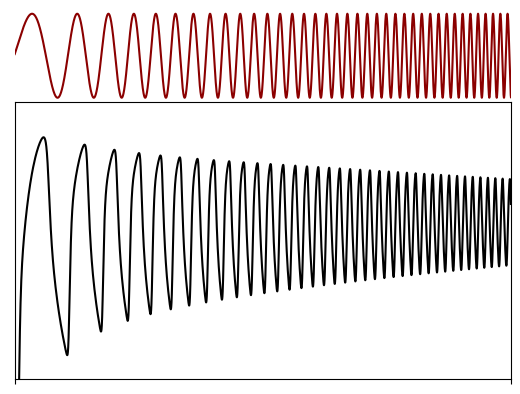

2-element Vector{Nothing}:
 nothing
 nothing

In [96]:
## Plotting
out = get_sum(sol,:Rtg3_n, dynmodel_freq)
input = get_sum(sol,:s, dynmodel_freq)




fig,ax = plt.subplots(2,1; gridspec_kw= Dict(:height_ratios=> [1, 3]))

ax[1].plot(0:0.1:600, SINEV.(0:0.1:600); color="darkred", linewidth=1.5) # Input
ax[2].plot(sol.t, out;color="black", linewidth=1.5) #Output 


# Axis
ax[1].axis("off")

ax[2].yaxis.set_ticks([])
ax[2].xaxis.set_ticks([30, 450])

ax[2].set_xticklabels(["",""])
ax[2].set_xlim(30,450)
ax[1].set_xlim(30,450)
ax[2].set_ylim(250,350)


#ax[2].set_ylabel("Output", fontsize="20")
#ax[2].set_xlabel("Time", fontsize="20")




fig.subplots_adjust(
    hspace=0.
)

f = Fig(fig, ax, "Freq_low_high")
[save(f,"FreqVariant", "FrequencyResponse/result/GraphicalAbstract";format=i) for i in ["pdf", "svg"]]